# Import

In [16]:
import os
import random

import pandas as pd
import numpy as np

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim

from sklearn.metrics import log_loss
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
!pip install inplace-abn

  Using cached inplace-abn-1.1.0.tar.gz (137 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  √ó python setup.py egg_info did not run successfully.
  ‚îÇ exit code: 1
  ‚ï∞‚îÄ> [16 lines of output]
      C:\Users\bug95\AppData\Local\Temp\pip-install-mrnx_gxy\inplace-abn_064c1312b6ac43a28c64765620bb1847\setup.py:25: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
        if torch.has_cuda:
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 35, in <module>
        File "C:\Users\bug95\AppData\Local\Temp\pip-install-mrnx_gxy\inplace-abn_064c1312b6ac43a28c64765620bb1847\setup.py", line 27, in <module>
          CUDAExtension(
        File "C:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\torch\utils\cpp_extension.py", line 1078, in CUDAExtension
          library_dirs += library_paths(cuda=True)
                          ^^^^^^^^^^^^^^^^^^^^^^^^
        File "C:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib

In [3]:
!git clone https://github.com/Alibaba-MIIL/TResNet
%cd TResNet

c:\Users\bug95\DaconHectoAIChallenge\TResNet


fatal: destination path 'TResNet' already exists and is not an empty directory.
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Hyperparameter Setting

In [4]:
CFG = {
    'IMG_SIZE': 368,
    'BATCH_SIZE': 32,
    'EPOCHS': 10,
    'LEARNING_RATE': 1e-4,
    'SEED' : 42
}

In [5]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Currently logged in as: superl3 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
# Initialize wandb
wandb.init(
    entity='Dacon_Car',
    project="car-classification",  # your project name
    name='TResNet',
    config=CFG  # this will log your hyperparameters
)

wandb: Currently logged in as: superl3 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Fixed RandomSeed

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed Í≥†Ï†ï

# CustomDataset

In [8]:
import os
from PIL import Image
import numpy as np # NumPy ÏûÑÌè¨Ìä∏ Ï∂îÍ∞Ä
from torch.utils.data import Dataset
# albumentationsÏôÄ ToTensorV2 ÏûÑÌè¨Ìä∏Îäî Dataset ÌÅ¥ÎûòÏä§ Ïô∏Î∂ÄÏóêÏÑú Ïù¥Î£®Ïñ¥Ï†∏Ïïº Ìï©ÎãàÎã§.
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        self.samples = []

        if is_test:
            # ÌÖåÏä§Ìä∏ÏÖã: ÎùºÎ≤® ÏóÜÏù¥ Ïù¥ÎØ∏ÏßÄ Í≤ΩÎ°úÎßå Ï†ÄÏû•
            for fname in sorted(os.listdir(root_dir)):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')): # Ïù¥ÎØ∏ÏßÄ ÌôïÏû•Ïûê Ï∂îÍ∞Ä
                    img_path = os.path.join(root_dir, fname)
                    self.samples.append((img_path,))
        else:
            # ÌïôÏäµÏÖã: ÌÅ¥ÎûòÏä§Î≥Ñ Ìè¥Îçî Íµ¨Ï°∞ÏóêÏÑú ÎùºÎ≤® Ï∂îÏ∂ú
            self.classes = sorted(os.listdir(root_dir))
            self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

            for cls_name in self.classes:
                cls_folder = os.path.join(root_dir, cls_name)
                # Ìè¥ÎçîÍ∞Ä ÏïÑÎãå ÌååÏùºÏù¥ ÏûàÏùÑ Ïàò ÏûàÏúºÎØÄÎ°ú isdir Ï≤¥ÌÅ¨ Ï∂îÍ∞Ä
                if not os.path.isdir(cls_folder):
                    continue
                for fname in os.listdir(cls_folder):
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')): # Ïù¥ÎØ∏ÏßÄ ÌôïÏû•Ïûê Ï∂îÍ∞Ä
                        img_path = os.path.join(cls_folder, fname)
                        label = self.class_to_idx[cls_name]
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.samples[idx][0]
            image = Image.open(img_path).convert('RGB')
            # PIL Ïù¥ÎØ∏ÏßÄÎ•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
            image = np.array(image)

            if self.transform:
                # AlbumentationsÎäî ÎîïÏÖîÎÑàÎ¶¨Î•º Î∞òÌôòÌïòÎ©∞ 'image' ÌÇ§Ïóê Î≥ÄÌôòÎêú Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÏäµÎãàÎã§.
                transformed_data = self.transform(image=image)
                image = transformed_data['image'] # PyTorch ÌÖêÏÑú (C, H, W)

            return image
        else:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')
            # PIL Ïù¥ÎØ∏ÏßÄÎ•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
            image = np.array(image)

            if self.transform:
                # AlbumentationsÎäî ÎîïÏÖîÎÑàÎ¶¨Î•º Î∞òÌôòÌïòÎ©∞ 'image' ÌÇ§Ïóê Î≥ÄÌôòÎêú Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏûàÏäµÎãàÎã§.
                transformed_data = self.transform(image=image)
                image = transformed_data['image'] # PyTorch ÌÖêÏÑú (C, H, W)

            return image, label

# Data Load

In [ ]:
train_root = '/kaggle/input/car-classification/train'
test_root = '/kaggle/input/car-classification/test'

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 # PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôòÌïòÍ∏∞ ÏúÑÌï®
import numpy as np # AlbumentationsÎäî NumPy Î∞∞Ïó¥ÏùÑ ÏûÖÎ†•ÏúºÎ°ú Î∞õÏäµÎãàÎã§.
from PIL import Image # Ïù¥ÎØ∏ÏßÄ Î°úÎî©ÏùÑ ÏúÑÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨

# AlbumentationsÏùò train_transform
train_transform = A.Compose([
    # ResizeIfPadNeededÎäî Í∞ÄÎ°úÏÑ∏Î°ú ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú Ïù¥ÎØ∏ÏßÄÏùò Í∏¥ Î≥Ä ÎòêÎäî ÏßßÏùÄ Î≥ÄÏùÑ Î¶¨ÏÇ¨Ïù¥Ï¶àÌïú Îã§Ïùå,
    # ÏßÄÏ†ïÎêú ÌÅ¨Í∏∞Ïóê ÎßûÏ∂∞ Ìå®Îî©ÏùÑ Ï∂îÍ∞ÄÌï©ÎãàÎã§.
    # pad_height, pad_widthÎäî ÏµúÏ¢Ö Ï∂úÎ†• ÌÅ¨Í∏∞Î•º ÏùòÎØ∏Ìï©ÎãàÎã§.
    # ÎßåÏïΩ ÏõêÎ≥∏ ÎπÑÏú®ÏùÑ Ïú†ÏßÄÌïòÎ©¥ÏÑú Ìå®Îî©ÏúºÎ°ú Ï±ÑÏö∞Îäî Í≤ÉÏù¥ Î™©Ï†ÅÏù¥ÎùºÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÏù¥ LongestMaxSizeÏôÄ PadIfNeededÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    A.LongestMaxSize(max_size=CFG['IMG_SIZE'], interpolation=Image.BILINEAR),
    A.PadIfNeeded(min_height=CFG['IMG_SIZE'], min_width=CFG['IMG_SIZE'],
                border_mode=0, fill=(0,0,0)), # border_mode=0 (CONSTANT), valueÎäî Ìå®Îî© ÏÉâÏÉÅ

    # ÏùºÎ∞òÏ†ÅÏúºÎ°ú ÌïôÏäµ ÏãúÏóêÎäî Resize ÌõÑ NormalizeÎ•º ÎßéÏù¥ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    # torchvisionÏùò NormalizeÏôÄ ÎèôÏùºÌïú mean/std Í∞íÏùÑ ÏÇ¨Ïö©Ìï©ÎãàÎã§.
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0), # Ïù¥ÎØ∏ÏßÄ ÌîΩÏÖÄ Í∞íÏùò ÏµúÎåìÍ∞í (ÏùºÎ∞òÏ†ÅÏúºÎ°ú 255)

    # AlbumentationsÏùò ToTensorV2Îäî Ïù¥ÎØ∏ÏßÄÎ•º PyTorch ÌÖêÏÑúÎ°ú Î≥ÄÌôòÌïòÍ≥† Ï±ÑÎÑê ÏàúÏÑúÎ•º (H, W, C) -> (C, H, W)Î°ú Î≥ÄÍ≤ΩÌï©ÎãàÎã§.
    # torchvisionÏùò ToTensor()ÏôÄ Ïú†ÏÇ¨ÌïòÍ≤å ÎèôÏûëÌï©ÎãàÎã§.
    ToTensorV2()
])  

# AlbumentationsÏùò val_transform (train_transformÍ≥º ÎèôÏùºÌïòÍ≤å Íµ¨ÏÑ±)
val_transform = A.Compose([
    # Í≤ÄÏ¶ù ÏãúÏóêÎèÑ ÎèôÏùºÌïòÍ≤å Resize Î∞è NormalizeÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§.
    A.LongestMaxSize(max_size=CFG['IMG_SIZE'], interpolation=Image.BILINEAR),
    A.PadIfNeeded(min_height=CFG['IMG_SIZE'], min_width=CFG['IMG_SIZE'],
                border_mode=0, fill=(0,0,0)), # border_mode=0 (CONSTANT), valueÎäî Ìå®Îî© ÏÉâÏÉÅ
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0),
    ToTensorV2()    
])

C:\Users\bug95\AppData\Local\Temp\ipykernel_9484\993200429.py:13: UserWarning: Argument(s) 'fill_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=CFG['IMG_SIZE'], min_width=CFG['IMG_SIZE'],
C:\Users\bug95\AppData\Local\Temp\ipykernel_9484\993200429.py:31: UserWarning: Argument(s) 'fill_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=CFG['IMG_SIZE'], min_width=CFG['IMG_SIZE'],


Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏Ïö© ÌÖåÏä§Ìä∏ ÏΩîÎìú

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52395 (\N{HANGUL SYLLABLE CEOS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51704 (\N{HANGUL SYLLABLE JJAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu San

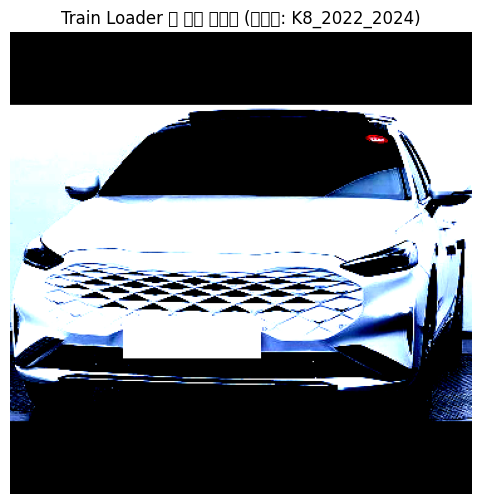

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bug95\.pyenv\pyenv-win\versions\3.12.4\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


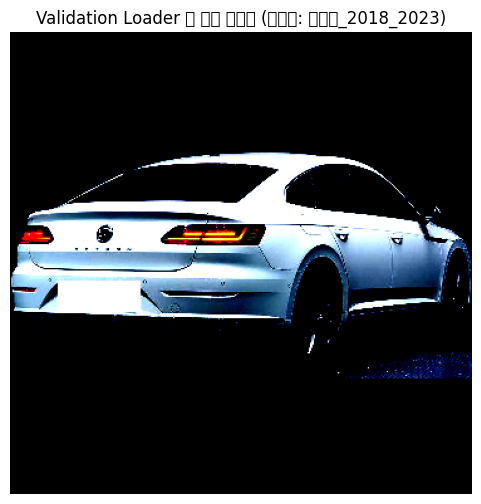

In [ ]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform Í∞ÅÍ∞Å Ï†ÅÏö©  
train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)
print(f'train Ïù¥ÎØ∏ÏßÄ Ïàò: {len(train_dataset)}, valid Ïù¥ÎØ∏ÏßÄ Ïàò: {len(val_dataset)}')


# DataLoader Ï†ïÏùò
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

import matplotlib.pyplot as plt
import numpy as np
import torch # torch ÏûÑÌè¨Ìä∏ Ï∂îÍ∞Ä

# DataLoaderÏóêÏÑú Ï≤´ Î≤àÏß∏ Î∞∞Ïπò Í∞ÄÏ†∏Ïò§Í∏∞
# train_loaderÎäî (Ïù¥ÎØ∏ÏßÄ ÌÖêÏÑú, ÎùºÎ≤® ÌÖêÏÑú)Ïùò ÌäúÌîåÏùÑ Î∞òÌôòÌï©ÎãàÎã§.
first_train_batch_images, first_train_batch_labels = next(iter(train_loader))

# Î∞∞ÏπòÏóêÏÑú Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ ÏÑ†ÌÉù
# PyTorch ÌÖêÏÑúÎäî Î≥¥ÌÜµ (Batch_size, Channel, Height, Width) ÌòïÌÉúÏûÖÎãàÎã§.
# Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÎ•º ÏÑ†ÌÉùÌïòÎ†§Î©¥ [0] Ïù∏Îç±Ïä§Î•º ÏÇ¨Ïö©ÌïòÍ≥†,
# matplotlibÏù¥ Í∑∏Î¶¥ Ïàò ÏûàÎèÑÎ°ù (Height, Width, Channel) ÌòïÌÉúÎ°ú Î≥ÄÌôòÌï¥Ïïº Ìï©ÎãàÎã§.
# ÎòêÌïú, AlbumentationsÏùò ToTensorV2Îäî 0-1 Î≤îÏúÑÎ°ú Ï†ïÍ∑úÌôîÌïòÎØÄÎ°ú, Í∑∏ÎåÄÎ°ú ÌëúÏãúÌï† Ïàò ÏûàÏäµÎãàÎã§.
first_train_image_tensor = first_train_batch_images[0]  
first_train_label = first_train_batch_labels[0].item() # ÎùºÎ≤® ÌÖêÏÑúÏóêÏÑú Ïã§Ï†ú Í∞í Ï∂îÏ∂ú

# ÌÖêÏÑúÎ•º NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôòÌïòÍ≥† Ï±ÑÎÑê ÏàúÏÑú Î≥ÄÍ≤Ω (C, H, W -> H, W, C)
image_np = first_train_image_tensor.permute(1, 2, 0).cpu().numpy()

# Ïù¥ÎØ∏ÏßÄ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title(f"Train Loader Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ (ÌÅ¥ÎûòÏä§: {class_names[first_train_label]})")
plt.axis('off') # Ï∂ï Ïà®Í∏∞Í∏∞
plt.show()

# ---

# val_loaderÏóêÏÑúÎèÑ ÎèôÏùºÌïòÍ≤å Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
first_val_batch_images, first_val_batch_labels = next(iter(val_loader))

first_val_image_tensor = first_val_batch_images[0]
first_val_label = first_val_batch_labels[0].item()

image_np_val = first_val_image_tensor.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(image_np_val)
plt.title(f"Validation Loader Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄ (ÌÅ¥ÎûòÏä§: {class_names[first_val_label]})")
plt.axis('off') # Ï∂ï Ïà®Í∏∞Í∏∞
plt.show()

In [ ]:
# Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
full_dataset = CustomImageDataset(train_root, transform=None)
print(f"Ï¥ù Ïù¥ÎØ∏ÏßÄ Ïàò: {len(full_dataset)}")

targets = [label for _, label in full_dataset.samples]
class_names = full_dataset.classes

# Stratified Split
train_idx, val_idx = train_test_split(
    range(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Subset + transform Í∞ÅÍ∞Å Ï†ÅÏö©  
train_dataset = Subset(CustomImageDataset(train_root, transform=train_transform), train_idx)
val_dataset = Subset(CustomImageDataset(train_root, transform=val_transform), val_idx)
print(f'train Ïù¥ÎØ∏ÏßÄ Ïàò: {len(train_dataset)}, valid Ïù¥ÎØ∏ÏßÄ Ïàò: {len(val_dataset)}')


# DataLoader Ï†ïÏùò
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)


# Model Define

In [ ]:
from src.models.tresnet_v2.tresnet_v2 import TResnetL_V2 as TResnetL368


class TResNet(nn.Module):
    def __init__(self, num_classes):
        super(TResNet, self).__init__()
        model_params = {'num_classes' : 196}
        self.backbone = TResnetL368(model_params)
        
        weights_path = "/kaggle/input/tresnet-stanford-cars-pretrained/stanford_cars_tresnet-l-v2_96_27.pth"
        pretrained_weights = torch.load(weights_path)
        
        self.backbone.load_state_dict(pretrained_weights['model'])  # TResnetL368 Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
        self.feature_dim = self.backbone.num_features
        self.backbone.head = nn.Identity()  # feature extractorÎ°úÎßå ÏÇ¨Ïö©
        self.head = nn.Linear(self.feature_dim, num_classes)  # Î∂ÑÎ•òÍ∏∞

    def forward(self, x):
        x = self.backbone(x)
        x = self.head(x)
        return x

# Train/ Validation

In [ ]:
model = TResNet(num_classes=len(class_names)).to(device)
best_logloss = float('inf')

# ÏÜêÏã§ Ìï®Ïàò
criterion = nn.CrossEntropyLoss()

# ÏòµÌã∞ÎßàÏù¥Ï†Ä
optimizer = optim.Adam(model.parameters(), lr=CFG['LEARNING_RATE'])

# ÌïôÏäµ Î∞è Í≤ÄÏ¶ù Î£®ÌîÑ
for epoch in range(CFG['EPOCHS']):
    # Train
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}/{CFG['EPOCHS']}] Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # LogLoss
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_logloss = log_loss(all_labels, all_probs, labels=list(range(len(class_names))))
    
    # wandb 
    wandb.log({
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss,
        "val_accuracy": val_accuracy,
        "val_logloss": val_logloss
    })
    
    # Í≤∞Í≥º Ï∂úÎ†•
    print(f"Train Loss : {avg_train_loss:.4f} || Valid Loss : {avg_val_loss:.4f} | Valid Accuracy : {val_accuracy:.4f}%")

    # Best model Ï†ÄÏû•
    if val_logloss < best_logloss:
        best_logloss = val_logloss
        torch.save(model.state_dict(), f'best_model.pth')
        print(f"üì¶ Best model saved at epoch {epoch+1} (logloss: {val_logloss:.4f})")

[Epoch 1/10] Training:   3%|‚ñé         | 28/829 [00:39<19:01,  1.43s/it]

# Inference

In [ ]:
test_dataset = CustomImageDataset(test_root, transform=val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

In [ ]:
# Ï†ÄÏû•Îêú Î™®Îç∏ Î°úÎìú
model = TResNet(num_classes=len(class_names))
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

# Ï∂îÎ°†
model.eval()
results = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)

        # Í∞Å Î∞∞ÏπòÏùò ÌôïÎ•†ÏùÑ Î¶¨Ïä§Ìä∏Î°ú Î≥ÄÌôò
        for prob in probs.cpu():  # prob: (num_classes,)
            result = {
                class_names[i]: prob[i].item()
                for i in range(len(class_names))
            }
            results.append(result)

pred = pd.DataFrame(results)

# Submission

In [ ]:
submission = pd.read_csv('/kaggle/input/car-classification/sample_submission.csv', encoding='utf-8-sig')

# 'ID' Ïª¨ÎüºÏùÑ Ï†úÏô∏Ìïú ÌÅ¥ÎûòÏä§ Ïª¨Îüº Ï†ïÎ†¨
class_columns = submission.columns[1:]
pred = pred[class_columns]

submission[class_columns] = pred.values
submission.to_csv('baseline_submission.csv', index=False, encoding='utf-8-sig')